# Audit trails for graph objects in ReGraph (aka versioning)

ReGraph implements a framework for the version control (VC) of graph transformations

The data structure `VersionedGraph` allows to store the history of transformations of a graph object and perform the following VC operations:

- _Rewrite_: perform a rewriting of the object with a commit to the revision history
- _Branch_: create a new branch (with a diverged version of the graph object)
- _Merge branches_: merge branches
- _Rollback_: rollback to a point in the history of transformations

In [1]:
from regraph import NXGraph
from regraph.audit import VersionedGraph
from regraph.rules import Rule
from regraph import print_graph, plot_rule, plot_graph

Create a graph and pass it to the `VersionedGraph` wrapper that will take care of the version control.

In [2]:
graph_obj = NXGraph()
g = VersionedGraph(graph_obj)

Now let's create a rule that adds to the graph two nodes connected with an edge and apply it. If we want the changes to be commited to the version control we rewrite through the `rewrite` method of a `VersioneGraph` object.

/home/eugenia/anaconda3/envs/kami/lib/python3.7/site-packages/matplotlib-3.0.3-py3.7-linux-x86_64.egg/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


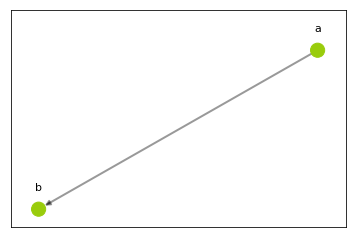

{'a': array([0.33902285, 1.        ]), 'b': array([-0.33902285, -1.        ])}

In [3]:
rule = Rule.from_transform(NXGraph())
rule.inject_add_node("a")
rule.inject_add_node("b")
rule.inject_add_edge("a", "b")

rhs_instance, _ = g.rewrite(rule, {}, message="Add a -> b")
plot_graph(g.graph)

We create a new branch called "branch"

In [4]:
branch_commit = g.branch("branch")

In [5]:
print("Branches: ", g.branches())
print("Current branch '{}'".format(g.current_branch()))

Branches:  ['master', 'branch']
Current branch 'branch'


Apply a rule that clones the node 'b' to the current vesion of the graph (branch 'branch')

/home/eugenia/anaconda3/envs/kami/lib/python3.7/site-packages/matplotlib-3.0.3-py3.7-linux-x86_64.egg/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


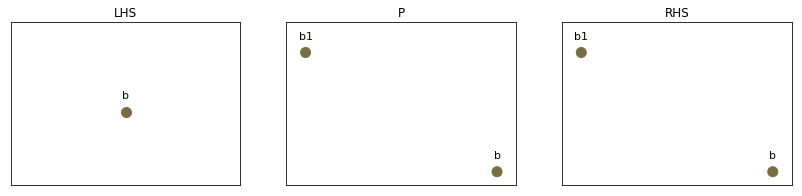

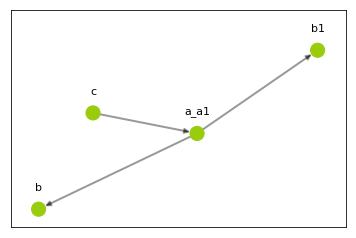

{'b': array([-0.49684359, -1.        ]),
 'c': array([-0.27689119,  0.16339026]),
 'a_a1': array([ 0.1433499 , -0.08449514]),
 'b1': array([0.63038488, 0.92110488])}

In [42]:
pattern = NXGraph()
pattern.add_node("b")
rule = Rule.from_transform(pattern)
rule.inject_clone_node("b")
plot_rule(rule)

rhs_instance, commit_id = g.rewrite(rule, {"b": rhs_instance["b"]}, message="Clone b")
plot_graph(g.graph)

The `rewrite` method of `VersionedGraph` returns the RHS instance of the applied and the id of the newly created commit corresponding to this rewrite.

In [43]:
print("RHS instance", rhs_instance)
print("Commit ID: ", commit_id)

RHS instance {'b': 'b1', 'b1': 'b'}
Commit ID:  afbab03b-2d7c-4363-a3c6-59c6032b9e5b


Switch back to the 'master' branch

In [7]:
g.switch_branch("master")
print(g.current_branch())

master


Apply a rule that adds a loop form 'a' to itself, a new node 'c' and connects it with 'a'

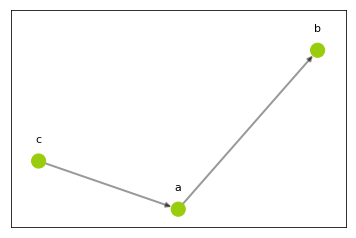

{'a': array([ 0.00064198, -0.27950696]),
 'b': array([0.99935802, 0.36401774]),
 'c': array([-1.        , -0.08451079])}

In [8]:
pattern = NXGraph()
pattern.add_node("a")
rule = Rule.from_transform(pattern)
rule.inject_add_node("c")
rule.inject_add_edge("c", "a")
rule.inject_add_edge("a", "a")

rhs_instance, _ = g.rewrite(rule, {"a": rhs_instance["a"]}, message="Add c and c->a")
plot_graph(g.graph)

Create a new branch 'dev'

In [9]:
g.branch("dev")

'06ef2284-e360-4733-87c6-dcae7602d3ef'

In this branch remove an edge from 'c' to 'a' and merge two nodes together

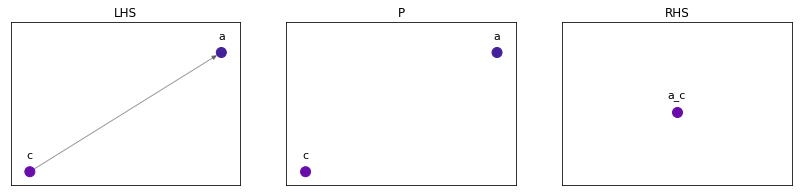

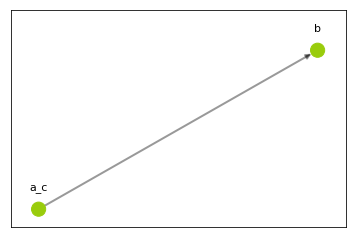

{'b': array([1.        , 0.26369224]),
 'a_c': array([-1.        , -0.26369224])}

In [10]:
pattern = NXGraph()
pattern.add_node("c")
pattern.add_node("a")
pattern.add_edge("c", "a")
rule = Rule.from_transform(pattern)
rule.inject_remove_edge("c", "a")
rule.inject_merge_nodes(["c", "a"])
plot_rule(rule)

g.rewrite(rule, {"a": rhs_instance["a"], "c": rhs_instance["c"]}, message="Merge c and a")
plot_graph(g.graph)

Switch back to the 'master' branch.

In [11]:
g.switch_branch("master")

Apply a rule that clones a node 'a'

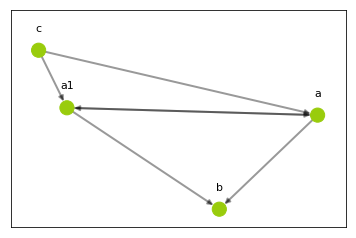

{'b': array([ 0.12810751, -1.        ]),
 'c': array([-0.26627629,  0.79400809]),
 'a': array([0.34258847, 0.06158105]),
 'a1': array([-0.20441969,  0.14441086])}

In [12]:
pattern = NXGraph()
pattern.add_node("a")
rule = Rule.from_transform(pattern)
_, rhs_clone = rule.inject_clone_node("a")
rhs_instance, rollback_commit = g.rewrite(rule, {"a": rhs_instance["a"]}, message="Clone a")
plot_graph(g.graph)

Create a new branch 'test'

In [13]:
g.branch("test")

'fb18eb3d-e663-4f3a-ad11-2fbd03336f87'

In this branch apply the rule that adds a new node 'd' and connects it with an edge to one of the cloned 'a' nodes

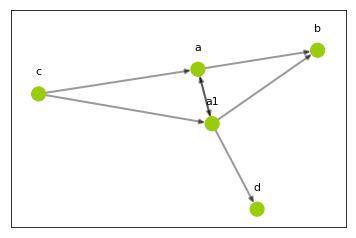

{'b': array([0.32183553, 0.59077041]),
 'c': array([-0.47327648,  0.15392861]),
 'a': array([-0.01921899,  0.40036811]),
 'a1': array([ 0.02119972, -0.14506712]),
 'd': array([ 0.14946022, -1.        ])}

In [14]:
pattern = NXGraph()
pattern.add_node("a")
rule = Rule.from_transform(pattern)
rule.inject_add_node("d")
rule.inject_add_edge("a", "d")
g.rewrite(rule, {"a": rhs_instance[rhs_clone]}, message="Add d -> clone of a")
plot_graph(g.graph)

Switch back to 'master'

In [15]:
g.switch_branch("master")

Remove a node 'a'

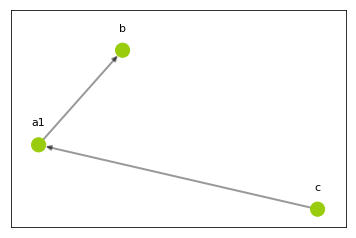

{'b': array([-0.08485235,  1.        ]),
 'c': array([ 0.36208559, -0.8806661 ]),
 'a1': array([-0.27723325, -0.1193339 ])}

In [16]:
pattern = NXGraph()
pattern.add_node("a")
rule = Rule.from_transform(pattern)
rule.inject_remove_node("a")
rhs_instance, _ = g.rewrite(rule, {"a": rhs_instance["a"]}, message="Remove a")
plot_graph(g.graph)

Merge the branch 'dev' into 'master'

In [17]:
g.merge_with("dev")

'7787c77f-c44d-4419-9416-155b139b6e9d'

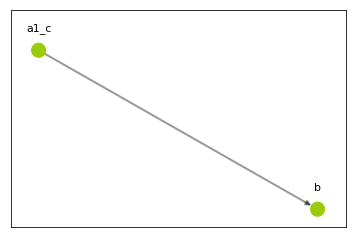

{'b': array([ 1.        , -0.01537886]),
 'a1_c': array([-1.        ,  0.01537886])}

In [18]:
plot_graph(g.graph)

Merge 'test' into 'master'

In [19]:
g.merge_with("test")

'd86ac7e8-8868-435d-a108-805341097170'

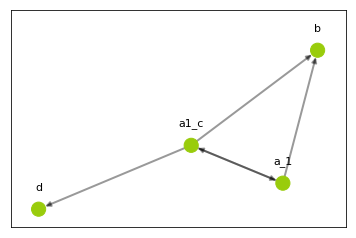

{'b': array([0.65118029, 0.57589966]),
 'a1_c': array([-0.09686575,  0.00985688]),
 'd': array([-1.        , -0.37030635]),
 'a_1': array([ 0.44568545, -0.21545019])}

In [20]:
plot_graph(g.graph)

We can inspect the version control object in more details and look at its attribute `_revision_graph`, whose nodes represent the commits and whose edges represent graph deltas between different commits (basically, rewriting rules that constitute commits). Here we can see that on the nodes of the revision graph are stored branch names to which commits belong and user specified commit messages.

In [29]:
import json
for n, attrs in g._revision_graph.nodes(data=True):
    print("Node ID: ", n)
    print("Attributes: ")
    print("\t", attrs)

Node ID:  0f29d379-e76a-4433-bcc2-97082776b4b6
Attributes: 
	 {'branch': 'master', 'message': 'Initial commit', 'time': datetime.datetime(2020, 1, 24, 14, 13, 3, 731569)}
Node ID:  499f6881-ce03-4463-9000-8d4ba714599b
Attributes: 
	 {'branch': 'master', 'time': datetime.datetime(2020, 1, 24, 14, 13, 17, 508136), 'message': 'Add a -> b'}
Node ID:  a98d7050-be6c-444e-9e1e-c02f40a6efc4
Attributes: 
	 {'branch': 'branch', 'time': datetime.datetime(2020, 1, 24, 14, 13, 21, 678884), 'message': "Created branch 'branch'"}
Node ID:  ee04e1dd-e276-4023-8fd4-299d698f26a1
Attributes: 
	 {'branch': 'branch', 'time': datetime.datetime(2020, 1, 24, 14, 13, 26, 471732), 'message': 'Clone b'}
Node ID:  cf32caf3-9c36-4c3b-9119-0472b06c09fc
Attributes: 
	 {'branch': 'master', 'time': datetime.datetime(2020, 1, 24, 14, 13, 35, 370027), 'message': 'Add c and c->a'}
Node ID:  06ef2284-e360-4733-87c6-dcae7602d3ef
Attributes: 
	 {'branch': 'dev', 'time': datetime.datetime(2020, 1, 24, 14, 13, 37, 486220), 'me

In [30]:
# Pretty-print the history
g.print_history()

2020-01-24 14:13:03.731569 0f29d379-e76a-4433-bcc2-97082776b4b6 master Initial commit
2020-01-24 14:13:17.508136 499f6881-ce03-4463-9000-8d4ba714599b master Add a -> b
2020-01-24 14:13:21.678884 a98d7050-be6c-444e-9e1e-c02f40a6efc4 branch Created branch 'branch'
2020-01-24 14:13:26.471732 ee04e1dd-e276-4023-8fd4-299d698f26a1 branch Clone b
2020-01-24 14:13:35.370027 cf32caf3-9c36-4c3b-9119-0472b06c09fc master Add c and c->a
2020-01-24 14:13:37.486220 06ef2284-e360-4733-87c6-dcae7602d3ef dev Created branch 'dev'
2020-01-24 14:13:39.841916 acd5c76f-98b3-40ab-9df9-8e657483f246 dev Merge c and a
2020-01-24 14:13:42.991329 a7d13243-df91-42c5-a38c-16240fa0ae2c master Clone a
2020-01-24 14:13:44.766558 fb18eb3d-e663-4f3a-ad11-2fbd03336f87 test Created branch 'test'
2020-01-24 14:13:46.703745 d79e9972-5d9d-4dc6-9ccb-60a15e34ff64 test Add d -> clone of a
2020-01-24 14:13:49.858790 5fc6208f-03e2-4134-bc36-1daac67a8359 master Remove a
2020-01-24 14:13:51.439732 7787c77f-c44d-4419-9416-155b139b6e9

Now we can rollback to some previous commit (commit where we first cloned the node 'a')

In [31]:
g.rollback(rollback_commit)

Created the new head for 'dev'
Created the new head for 'master'


Branches:  ['master', 'branch', 'dev']
Current branch 'master'
Updated revision graph:
2020-01-24 14:13:03.731569 0f29d379-e76a-4433-bcc2-97082776b4b6 master Initial commit
2020-01-24 14:13:17.508136 499f6881-ce03-4463-9000-8d4ba714599b master Add a -> b
2020-01-24 14:13:21.678884 a98d7050-be6c-444e-9e1e-c02f40a6efc4 branch Created branch 'branch'
2020-01-24 14:13:26.471732 ee04e1dd-e276-4023-8fd4-299d698f26a1 branch Clone b
2020-01-24 14:13:35.370027 cf32caf3-9c36-4c3b-9119-0472b06c09fc master Add c and c->a
2020-01-24 14:13:37.486220 06ef2284-e360-4733-87c6-dcae7602d3ef dev Created branch 'dev'
2020-01-24 14:13:39.841916 acd5c76f-98b3-40ab-9df9-8e657483f246 dev Merge c and a
2020-01-24 14:13:42.991329 a7d13243-df91-42c5-a38c-16240fa0ae2c master Clone a
Current graph object


/home/eugenia/anaconda3/envs/kami/lib/python3.7/site-packages/matplotlib-3.0.3-py3.7-linux-x86_64.egg/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


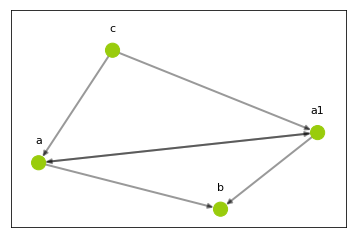


Nodes:

b  :  {}
a1  :  {}
a  :  {}
c  :  {}

Edges:

a1 -> a1  :  {}
a1 -> b  :  {}
a1 -> a  :  {}
a -> a  :  {}
a -> a1  :  {}
a -> b  :  {}
c -> a  :  {}
c -> a1  :  {}


In [32]:
print("Branches: ", g.branches())
print("Current branch '{}'".format(g.current_branch()))
print("Updated revision graph:")
g.print_history()
print("Current graph object")
plot_graph(g.graph)
print_graph(g.graph)

In [33]:
g.switch_branch("branch")

In [34]:
g.rollback(branch_commit)

Created the new head for 'branch'


In [35]:
g.print_history()

2020-01-24 14:13:03.731569 0f29d379-e76a-4433-bcc2-97082776b4b6 master Initial commit
2020-01-24 14:13:17.508136 499f6881-ce03-4463-9000-8d4ba714599b master Add a -> b
2020-01-24 14:13:21.678884 a98d7050-be6c-444e-9e1e-c02f40a6efc4 branch Created branch 'branch'
2020-01-24 14:13:35.370027 cf32caf3-9c36-4c3b-9119-0472b06c09fc master Add c and c->a
2020-01-24 14:13:37.486220 06ef2284-e360-4733-87c6-dcae7602d3ef dev Created branch 'dev'
2020-01-24 14:13:39.841916 acd5c76f-98b3-40ab-9df9-8e657483f246 dev Merge c and a
2020-01-24 14:13:42.991329 a7d13243-df91-42c5-a38c-16240fa0ae2c master Clone a


{'master': 'a7d13243-df91-42c5-a38c-16240fa0ae2c', 'branch': 'a98d7050-be6c-444e-9e1e-c02f40a6efc4', 'dev': 'acd5c76f-98b3-40ab-9df9-8e657483f246'}


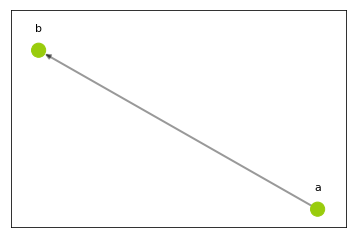

{'a': array([ 1.        , -0.18812734]),
 'b': array([-1.        ,  0.18812734])}

In [36]:
print(g._heads)
plot_graph(g.graph)

In [37]:
g.switch_branch("master")

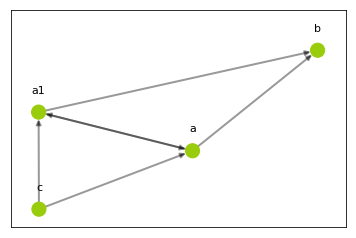

{'a': array([ 0.17794836, -0.25132721]),
 'b': array([0.66576723, 1.        ]),
 'a1': array([-0.42251654,  0.22978428]),
 'c': array([-0.42119906, -0.97845708])}

In [38]:
plot_graph(g.graph)

In [39]:
g.merge_with("branch")

'54e47a90-bd19-4076-9925-340ec8adddf4'

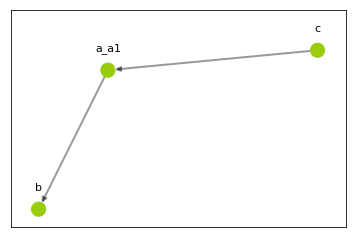

{'b': array([-0.68410174, -1.        ]),
 'c': array([0.95987946, 0.60037515]),
 'a_a1': array([-0.27577771,  0.39962485])}

In [40]:
plot_graph(g.graph)